# Random Circuit Sampling Using Qiskit and IBM Backends

The motivation for this experiment arises from a [notebook](IBM_notebook_HardwareEfficientLayerCircuits.html) sent by IBM to us on April 12th, 2023. Here, we reconstruct the experiment depicted in IBM's notebook as best as we can with our available resources. In addition, we perform some adjustments to make this experiment as much as similar to Google's Sycamore supremacy experiment.

## The backend

The quantum computer chosen for the experiment is `ibm_nairobi`. It has $7$ qubits, and in particular - we can pick a linearly connected chain of `n = 5` qubits to perform the experiment upon (In IBM's notebook, they pick a linear chain of $7$ qubits on a larger machine). The connectivity map of `ibm_nairobi`:

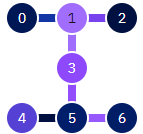

It can be seen that there are $4$ options of qubit-chains to pick from: [0, 1, 3, 5, 6], [0, 1, 3, 5, 4], [2, 1, 3, 5, 6] or [2, 1, 3, 5, 4]. We let the transpiler pick the chain for us (it automatically picks the least noisy chain).

## The circuit

Similarly to IBM's method, we are generating a circuit that yields Porter-Thomas distributions that is constructed by alternating layers of Haar-random single-qubit unitaries, followed by entangling layers, which in turn alternate among themselves between connected pair of qubits. Here we choose `m = 9` layers:

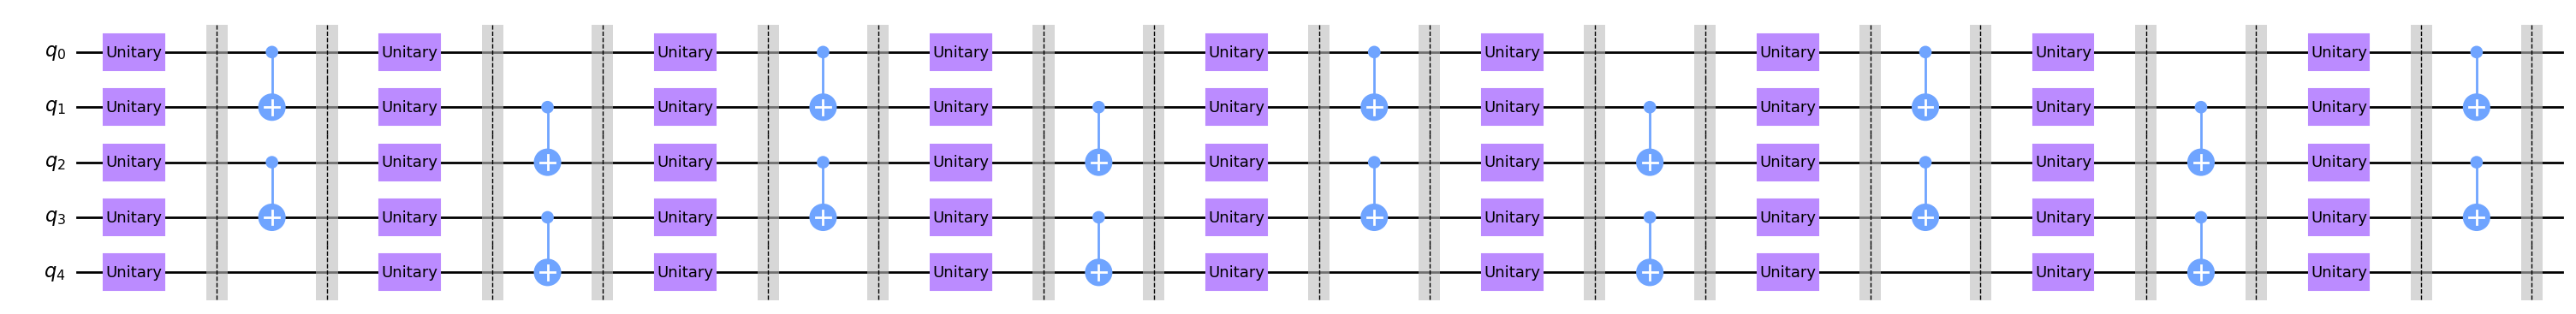

In [1]:
from gen_haar_random_circuit import gen_haar_random_circuit

num_qubits = 5 # n
num_layers = 9 # m

gen_haar_random_circuit(num_qubits, num_layers).draw("mpl", fold=-1)

When transpiling the above circuit for `ibm_nairobi`, each single-qubit Haar-random unitary is decomposed to a sequence of $5$ native gates of `ibm_nairobi`, namely the sequence of $ Rz(\theta_0)\ \sqrt{X}\ Rz(\theta_1)\ \sqrt{X}\ Rz(\theta_2)$ gates, where $\theta_i$ are just the rotations needed to perform each specific gate.

In addition, the transpiler chooses the least error-prone $5$-qubits linearly connected chain of `ibm_nairobi`, and maps the logical qubits from the above high-level circuit onto the physical qubits of `ibm_nairobi`.

Hence, the transpiled circuit which has been executed on `ibm_nairobi` looks as follows:

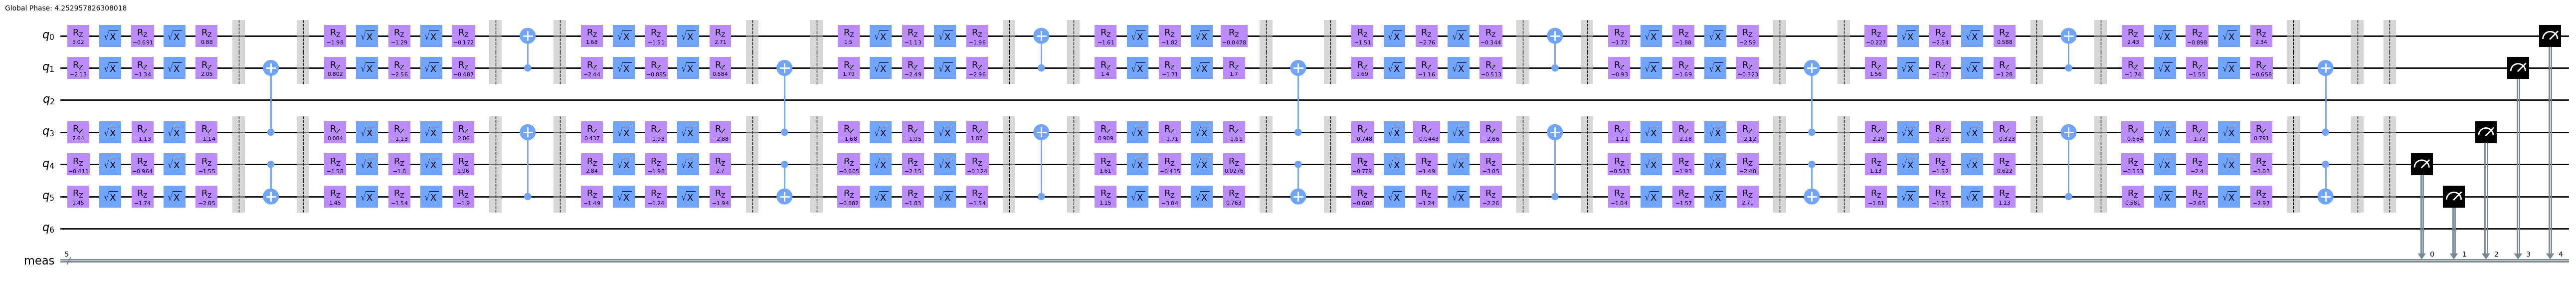

In [3]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
job = provider.retrieve_job("ci8l92h02cefj719sc50")

job.circuits()[0].draw("mpl", fold=-1)

It also shall be remembered that $Rz$ gates are implemented virtually and therefore immune to quantum noise.

We chose a number of layers of `m = 9` because it yields a circuit of depth similar to Google's circuits with `m = 14` that we have already tested:

In [4]:
depth = job.circuits()[0].depth()
num_rz_gates = num_layers * 3

print("Circuit depth:", depth)
print("Number of noiseless Rz gates:", num_rz_gates)
print("Susceptible-to-noise circuit depth:", depth - num_rz_gates)

Circuit depth: 55
Number of noiseless Rz gates: 27
Susceptible-to-noise circuit depth: 28


## Execution and Results

We have chosen the maximum allowed number of executions, hence the above circuit has been executed `shots = 100_000` times. Though it's not that important, we now plot the resulted probability distributions, to get some "sense" of the results:

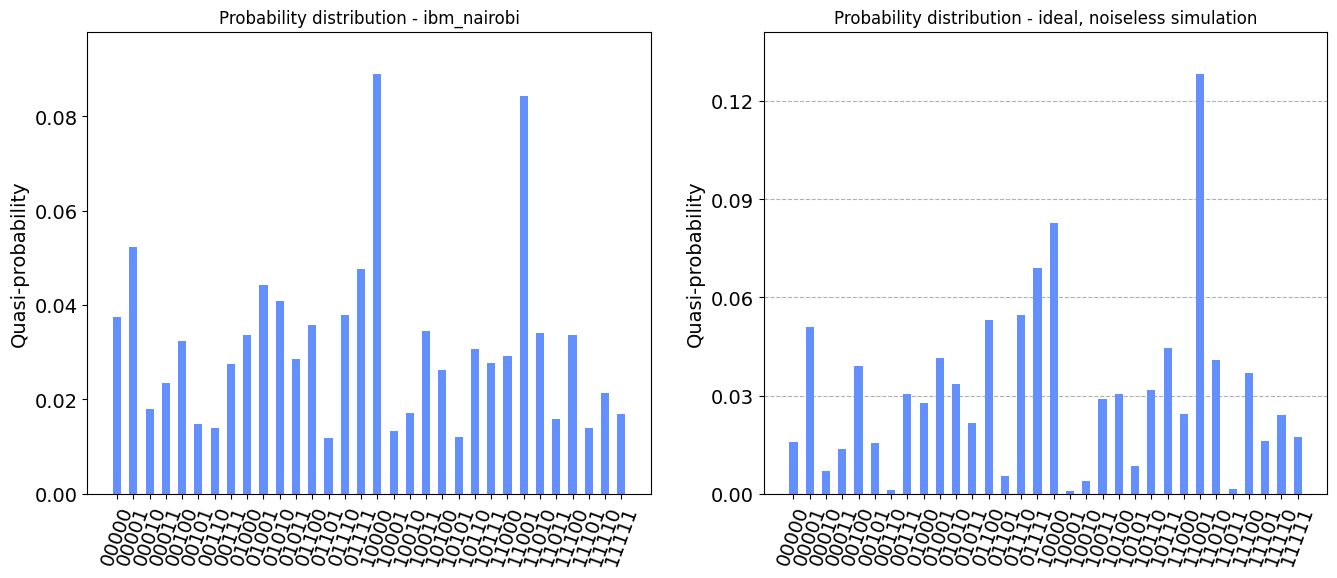

In [86]:
from qiskit_aer import AerSimulator
from qiskit.circuit import Qubit, QuantumRegister
from qiskit.visualization import plot_distribution

from matplotlib import pyplot as plt


shots = job.backend_options()["shots"]


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].set_title("Probability distribution - ibm_nairobi")
nairobi_counts = job.result().get_counts()
nairobi_p_dist = {k: v / shots for k, v in sorted(nairobi_counts.items())}
plot_distribution(nairobi_p_dist, bar_labels=False, ax=axes[0]) # Real backend

axes[1].set_title("Probability distribution - ideal, noiseless simulation")
ideal_counts = AerSimulator().run(job.circuits()[0], shots=shots).result().get_counts()
ideal_p_dist = {k: v / shots for k, v in sorted(ideal_counts.items())}
plot_distribution(ideal_p_dist, bar_labels=False, ax=axes[1]) # Ideal simulator

Now, we can check for $\mathcal{F}_{XEB}(\vec{p}_1, \vec{p}_2)$, where $\vec{p}_1$ is the ideal probability distribution vector, and $\vec{p}_2$ is the noisy one, generated by `ibm_nairobi`:

In [87]:
from typing import Iterable

import numpy as np


def compute_f_xeb(p1, p2, hilbert_dim):
    return (hilbert_dim * np.dot(p1, p2)) - 1

print(
    "F_xeb(p1, p2) =",
    compute_f_xeb(
        np.array(list(ideal_p_dist.values())),
        np.array(list(nairobi_p_dist.values())),
        hilbert_dim=2**num_qubits
    )
)

F_xeb(p1, p2) = 0.43651793920000004


We can even perform a simple sanity check for this result, using formula $(77)$ from [1]:

$$ F = \prod^{}_{g\ \in\ G_1} (1 - e_g) \prod^{}_{g\ \in\ G_2} (1 - e_g) \prod^{}_{q\ \in\ Q} (1 - e_q) \tag{77} $$

Where $e_g \in G_1$ are single-qubit gate errors, $e_g \in G_2$ are two-qubit gate errors, and $q \in Q$ are SPAM errors for each qubit. For the sake of our sanity check, we just feed into this equation the maximal errors for each category (taken from the characterization data of `ibm_nairobi`):

In [92]:
print("Gates count:", job.circuits()[0].count_ops())
print()

f_77 = (1 - 1.771e-2)**18 * (1 - 1.327e-3)**90 * (1 - 6.870e-2)**5
print("F =", f_77)

Gates count: OrderedDict([('rz', 135), ('sx', 90), ('barrier', 19), ('cx', 18), ('measure', 5)])

F = 0.4506722225342678


It can be seen that the results roughly agree with each other.

## References

[[1]](https://arxiv.org/abs/1910.11333) Google Quantum AI. **Supplementary information for "Quantum supremacy using a programmable superconducting processor"**. *arXiv:1910.11333, 2019*.